<a href="https://colab.research.google.com/github/cagBRT/computer-vision/blob/master/CV9a_SemanticSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone -l -s https://github.com/cagBRT/computer-vision.git cloned-repo
%cd cloned-repo

Cloning into 'cloned-repo'...
remote: Enumerating objects: 3911, done.
remote: Counting objects: 100% (222/222), done.
remote: Compressing objects: 100% (163/163), done.
remote: Total 3911 (delta 118), reused 106 (delta 59), pack-reused 3689
Receiving objects: 100% (3911/3911), 442.55 MiB | 20.63 MiB/s, done.
Resolving deltas: 100% (1453/1453), done.
Updating files: 100% (2299/2299), done.
/content/cloned-repo


In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms

# **Semantic Segmentation**
This notebook uses PyTorch to perform semantic segmentation on images.

The goal of semantic image segmentation is to label each pixel of an image with a corresponding class of what is being represented. Because we're predicting for every pixel in the image, this task is commonly referred to as dense prediction.

One important thing to note is that *we're not separating instances of the same class; we only care about the category of each pixel*. In other words, if you have two objects of the same category in your input image, the segmentation map does not inherently distinguish these as separate objects. There exists a different class of models, known as *instance segmentation models, which do distinguish between separate objects of the same class*.

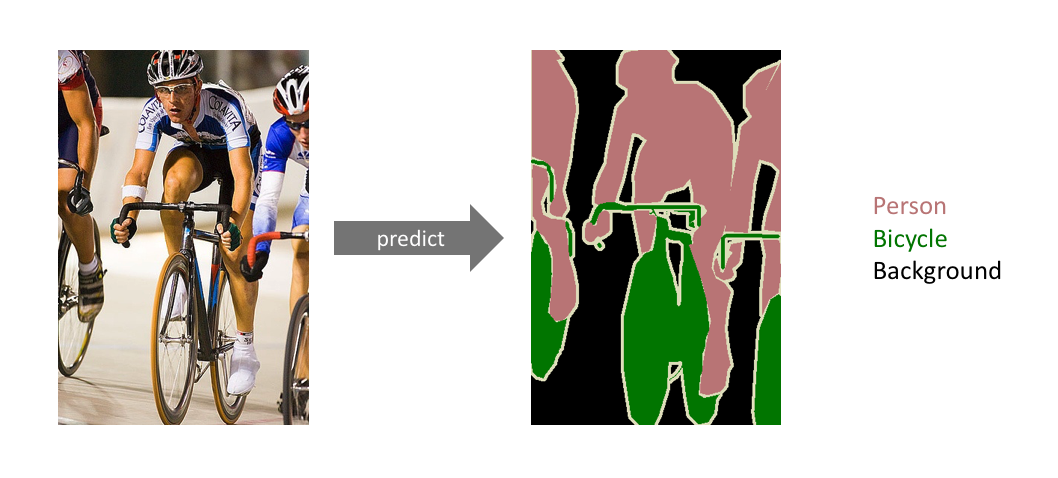

In [3]:
import cv2
from google.colab.patches import cv2_imshow
image = cv2.imread("/content/cloned-repo/images/bikeRiders.png")
cv2_imshow(image)

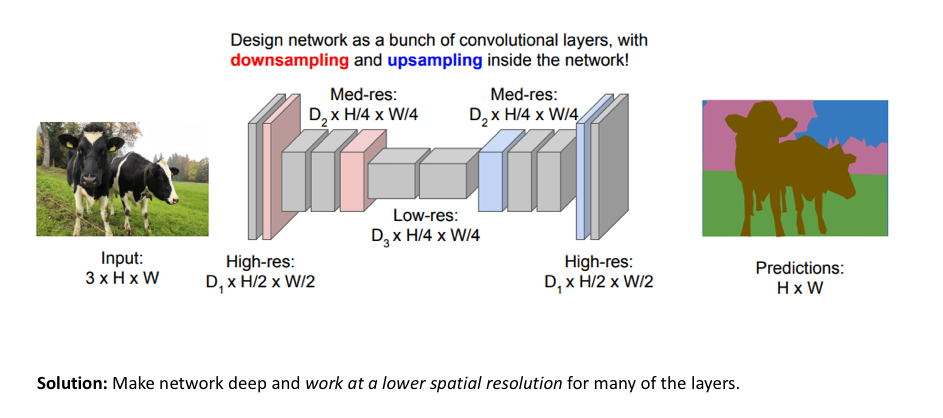

In [4]:
image = cv2.imread("/content/cloned-repo/images/semanticSegmentationArch2.png")
cv2_imshow(image)

**Pytorch Hub**<br>
Pytorch Hub is a pre-trained model repository designed to facilitate research reproducibility.


All of the pre-trained models expect input images normalized in the same way,<br> i.e. mini-batches of 3-channel RGB images of shape (N, 3, H, W), where N is the number of images, H and W are expected to be at least 224 pixels. <br>
The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

The model returns an OrderedDict with two Tensors that are of the same height and width as the input Tensor, but with 21 classes. output['out'] contains the semantic masks, and output['aux'] contains the auxillary loss values per-pixel. In inference mode, output['aux'] is not useful. So, output['out'] is of shape (N, 21, H, W).



**The model**<br>
DeepLabV3 model with a ResNet-101 backbone.<br>
Deeplabv3-ResNet101 is constructed by a Deeplabv3 model with a ResNet-101 backbone. <br>

The pre-trained model has been trained on a subset of [COCO train2017](https://cocodataset.org/#explore), on the 20 categories that are present in the Pascal VOC dataset<br>

This model has a Global Pixelwise Accuracy of 92.4

**Backbone**<br>
Backbone is a term used in DeepLab models/papers to refer to the feature extractor network. These feature extractor networks compute features from the input image and then these features are upsampled by a simple decoder module of DeepLab models to generate segmented masks. The authors of DeepLab models have shown performance with different feature extractors (backbones) like MobileNet, ResNet, and Xception network.

In [5]:
torch.hub._validate_not_a_forked_repo=lambda a,b,c: True
model = torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /root/.cache/torch/hub/v0.6.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:02<00:00, 92.0MB/s]


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

**Select an image and do the preprocessing**<br>
1. Normalize the pixel values in the image
2. Modify the format of the image to one expected by the model

In [6]:
# sample execution (requires torchvision)

input_image = Image.open("images/Navajo_people_and_sheep.jpg")
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

**Prepare for GPU usage**<br>
Computer vision models are compuationally intense, using GPUs reduces processing time.

In [7]:
# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

**No Grad**<br>
Disabling gradient calculation is useful for inference, when you are sure that you will not call Tensor.backward(). It will reduce memory consumption for computations that would otherwise have requires_grad=True.

In [8]:
with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)

**The Color Palette**<br>
Select the color palette and colors for each class.<br>
Could also use PaletteNet

In [9]:
# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

**Plot the semantic segmentation of the image**

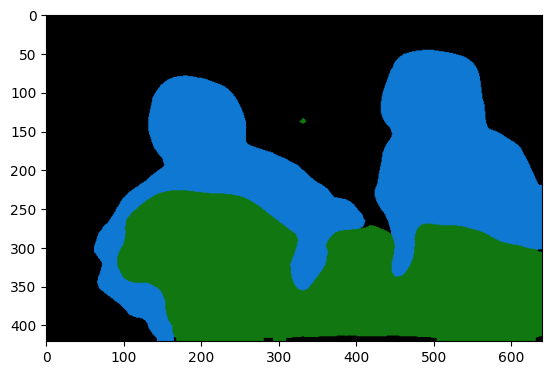

In [10]:
# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
r.putpalette(colors)

plt.imshow(r)
plt.show()

**Compare the segmented image to the original image**

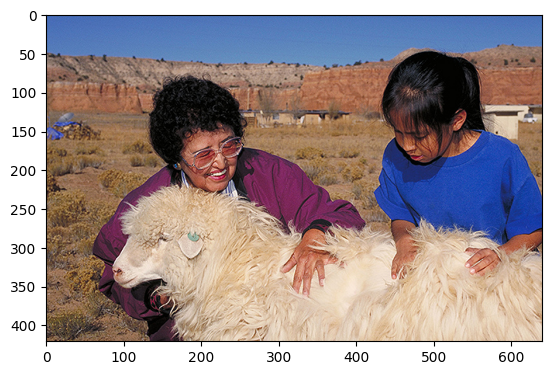

In [11]:
plt.imshow(input_image)
plt.show()

# **Assignment**
Pick an image in the /content/cloned-repo/images directory and apply the semantic segmentation algorithm on it.